# Classifying Gender and Ethnicity based on Facial Images.

<img src="./assume-gender.jpg" width="600" align="center">

### Author: Denislav Dyakov

## Abstract

In this paper, we analyze image data from around 23,000 face images. After some data processing, scaling and dimensionality reduction, we build two classification models - one for classifying Gender and one for Ethnicity. For the former we select 5 classification algorithms, tune and cross-validate them and select the best performing one. In our case, looking at both classificatin scores and execution times, the best model turns out to be a Logistic Regression. It provides a weighted F1 score of 84% and gets fitted in less than two seconds. For the Ethnicity model we focus more on the fact that the data is highly imbalanced. There we try both over and undersampling and chose the former technique. We compare the performance of a Logistic Regression and Random Forest. The former achives F1 of 66% and the latter - 59%. They both predict the minority class equally bad (weighted F1 score of around 25%) and once again the Logistic Regression is much faster. This paper provides support for the coinage that a simple model is usually better.

## Introduction

Computer vision is defined as a scientific field that seeks to understand and mimic the the human visual system's ability.[1]
It's beginnings date back to the 1960s and since then numeros applications of computer vision emerged in medicine, manufacturing, surveilance and navigation to list a few.

Currently computer vision is one of the most researched fields of artificial intelligence mainly due to developments in neural networks and deep learning approaches[2]. Some of the computer vision techniques include:

- Image Classification - based on a set of images that are labeled to two or several categories, we try to predict the categories of a novel set of images. Currently the most popular architecture for this taks is Convolutional Newral Networks.


- Object Detection - defining an object within an image, usually by generating a box and/or a label at the location of the object.


- Object Tracking - following an object of interest in a video 


- Semantic Segmentation - dividing images into pixel groupings and trying to understand the role of each pixel in the image.

In this paper, we will focus on the first technique - Image Classification. To perform that, we will use the approach called 'Eigenfaces'.  

## Previous Research

Since it's development in 1987, Eigenfaces has been extensively researched. Nowadays, however other techniques seem to be prefered for face recognition.

There is only a handfull of submissions on Kaggle on classifying facial images with Eigenfaces and none for this particular dataset. Submissions that have used NN techniques for classification have reported classification scored in the upper 80% and lower 90% for both Gender and Ethnicity classification.

Our study builds upon previous research, as we:

- provide one of the more detailed analysis on this dataset
- have used a substancial amout of classifying algorithms and fine-tuned them to this dataset with the help of hyperparameter tuning
- provided an example of dealing with highly imbalanced datasets

## Conceptual framework

In this paper we will develop two separate models - one for classifying Gender and one for Ethnicity. For each of the models we will follow the listed steps:

- Scale the data
- Perform dimentionality reduction (PCA)
- For the severelyimbalanced dataset we will perform Over and Undersampling and pick the better performing one
- Apply several models, and perform hyperparameter tuning and cross validation
- Compare the model's performance and pick a winner

## Data Sources and Data Cleaning

In [61]:
#Importing general modules and data preparation modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import itertools

from PIL import Image, ImageOps
import matplotlib.image as mpimg
from IPython.display import Image as img

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#Importing modeling modules:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, roc_curve
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score, classification_report
import sklearn.metrics as metrics                                                 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

The dataset that we will use in this paper is called "UTKFace Large Scale Face Dataset". It consists of around 23,000 single face images that have been aligned and cropped in advance. The images are all of pizel size 200x200 and are color images. Each image is labelled by age, gender and ethnicity.

These labels are contained in the names of each file with the following naming convention: 

[age]\_[gender]\_[ethnicity]\_[rest-of-the-filename]

Age: values are all round numbers between 1 and 116

Gender: 0 for Male and 1 for Female

Ethnicity: 0 for White, 1 for Black, 2 for Indian, 3 for Asian and 4 for Other

Let us take a look at a random image.

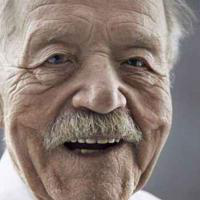

In [2]:
image = Image.open("UTKFace/100_0_0_20170112213500903.jpg.chip.jpg")
image

Let us try to simplify the image by resizing it to a pizel size of 100x100. 

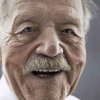

In [3]:
image = Image.open("UTKFace/100_0_0_20170112213500903.jpg.chip.jpg")
image = image.resize([100,100])
image

An RGB image with a size of 100x100 consists of three 100x100 arrays, which when flattened would produce a 1-D array of length 100 x 100 x 3 = 30,000. 

In [4]:
arr = np.array(image)
len(arr.ravel().tolist())

30000

For the purpose of this exercise, we will convert the RGB images into grayscale. This will convert three 100 x 100 arrays into a singe one and reduce the length of the flattened 1-D array to 100 x 100 = 10,000

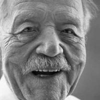

In [5]:
image = Image.open("UTKFace/100_0_0_20170112213500903.jpg.chip.jpg")
image = image.resize([100,100])
image = ImageOps.grayscale(image)
image

In [6]:
arr = np.array(image)
len(arr.ravel().tolist())

10000

Having obtained the images, we want to extract the relevant imformation from their titles and load it into a pandas dataframe.

In [7]:
def extract_filenames(path):
    
    filenames = []
    
    for files in os.listdir(path):
        if os.path.isfile(os.path.join(path, files)):
            filenames.append(files)
        
    return filenames   

In [8]:
list_of_files = extract_filenames("UTKFace/")

In [9]:
df_initial = pd.DataFrame(list_of_files, columns = ["filename"])

In [10]:
df_initial.head()

,filename
0,100_0_0_20170112213500903.jpg.chip.jpg
1,100_0_0_20170112215240346.jpg.chip.jpg
2,100_1_0_20170110183726390.jpg.chip.jpg
3,100_1_0_20170112213001988.jpg.chip.jpg
4,100_1_0_20170112213303693.jpg.chip.jpg


The dataframe should consist of a single column and should have a row number euqal to the number of images in the dataset.

In [11]:
df_initial.shape

(23708, 1)

Next we will repeat the exercise of converting the images to grayscale as well as flattening the 100 x 100 array of each image into a 1-D array. This array will then be appended to the corresponding file name in the dataframe above.

In [12]:
def convert_image_to_pixels(image):
    image_color = Image.open(image)
    image_color = image_color.resize([100,100])
    image_grayscale = ImageOps.grayscale(image_color)
    arr = np.array(image_grayscale).ravel()
    return arr.tolist()

In [13]:
def convert_multiple_images(path):
    
    pixels = []

    for files in os.listdir(path):
        if os.path.isfile(os.path.join(path, files)):
            pixels.append(convert_image_to_pixels(os.path.join(path, files)))
            
    return pixels

In [14]:
series = pd.Series(convert_multiple_images("UTKFace/"), name = "pixels")

In [15]:
df_initial = pd.concat([df_initial, series], axis=1)
df_initial.shape

(23708, 2)

In [16]:
df_initial.head()

,filename,pixels
0,100_0_0_20170112213500903.jpg.chip.jpg,"[207, 197, 197, 183, 146, 140, 147, 170, 178, ..."
1,100_0_0_20170112215240346.jpg.chip.jpg,"[124, 126, 126, 125, 126, 119, 100, 77, 71, 70..."
2,100_1_0_20170110183726390.jpg.chip.jpg,"[233, 235, 232, 154, 114, 112, 128, 145, 113, ..."
3,100_1_0_20170112213001988.jpg.chip.jpg,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8..."
4,100_1_0_20170112213303693.jpg.chip.jpg,"[70, 71, 72, 71, 82, 103, 131, 160, 161, 156, ..."


As we see, the 1-D array has been appended as a list of pixels. Let us now move each pixel from the list into a separate column.

In [17]:
#some housekeeping of objects that are no longer used
del series

In [18]:
df_pixels = pd.DataFrame(df_initial["pixels"].tolist())

In [19]:
df_pixels.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,207,197,197,183,146,140,147,170,178,178,...,104,103,102,101,99,98,97,96,95,95
1,124,126,126,125,126,119,100,77,71,70,...,180,164,154,146,142,142,144,145,145,143
2,233,235,232,154,114,112,128,145,113,115,...,203,211,216,225,237,242,247,251,255,255
3,82,82,82,82,82,82,82,82,82,82,...,102,101,116,109,95,103,102,104,95,87
4,70,71,72,71,82,103,131,160,161,156,...,147,145,143,149,145,129,124,125,126,127


The resulting dataframe contains all 10,000 pixels and their grayscale value. If we did everything correctly, we should be able to reconstrunct an image by reversing the flattening of the 1-D array back into a 100 x 100 array. Let us check this out:

In [20]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(100,100).astype('uint8')
    plt.imshow(temp, cmap='gray')

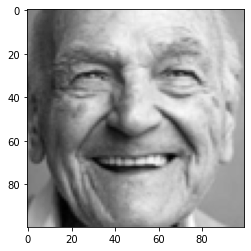

In [21]:
print_image(1, df_pixels)

It seems correct - we can now concatenate the pizels back to the file names.

In [22]:
df = pd.concat([df_initial, df_pixels], axis=1)
df = df.drop("pixels", axis = 1)
df.shape

(23708, 10001)

In [23]:
#some housekeeping of objects that are no longer used
del df_pixels

In [24]:
df.head()

,filename,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,100_0_0_20170112213500903.jpg.chip.jpg,207,197,197,183,146,140,147,170,178,...,104,103,102,101,99,98,97,96,95,95
1,100_0_0_20170112215240346.jpg.chip.jpg,124,126,126,125,126,119,100,77,71,...,180,164,154,146,142,142,144,145,145,143
2,100_1_0_20170110183726390.jpg.chip.jpg,233,235,232,154,114,112,128,145,113,...,203,211,216,225,237,242,247,251,255,255
3,100_1_0_20170112213001988.jpg.chip.jpg,82,82,82,82,82,82,82,82,82,...,102,101,116,109,95,103,102,104,95,87
4,100_1_0_20170112213303693.jpg.chip.jpg,70,71,72,71,82,103,131,160,161,...,147,145,143,149,145,129,124,125,126,127


Having extracted the pixel data, which is our features, we can proceed with extracting the Age, Gender and Ethnicity data from the titles of the pictures. The picture titles should contain data for the three columns, separated with an underscore (\_). Additionaly there should be some information that we will not make use of - information of the date and time of the picture, as well as the format. If the naming convention ahs been followed for all pictures, we should have three underscored in each picture title, separating the four data entities. Let us check if this is so.

In [25]:
print(df["filename"][df["filename"].str.count("_") != 3])

15015    39_1_20170116174525125.jpg.chip.jpg
20793    61_1_20170109142408075.jpg.chip.jpg
20794    61_1_20170109150557335.jpg.chip.jpg
Name: filename, dtype: object


As we can see, there is some missing data for three of the pictures. Since, no information is present in the documentation of the dataset, whether the '1' in these pictures stands for Gender or Ethnicity, we can inspect the pictures.

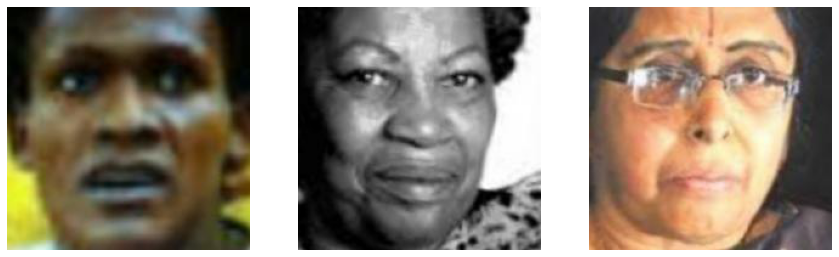

In [26]:
image_names = df["filename"][df["filename"].str.count("_") != 3].values.tolist()

images = []
for name in image_names:
    images.append(mpimg.imread("UTKFace/" + name))
    
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis("off")
    plt.imshow(image, cmap = "gray")
plt.show()

From what we can see, the faces in the three pictures rather share the same Ethnicity that the same Gender. We say this fully aware that we might enfuriate the "Social Justice Warriors". Nevertheless, we will take the risk and assume, from the inspected face images above, that the '1' in the titles stands for Ethnicity. 

We will impute the missing Gender data from our observations by augmenting the picture titles and manually adding '0' for male or '1' for female. Thus we make sure that all images follow the same naming convention and that we can later split the column and extract the correct data for all images.

In [27]:
df.at[15015, "filename"] = '39_0_1_20170116174525125.jpg.chip.jpg'
df.at[20793, "filename"] = '61_1_1_20170109142408075.jpg.chip.jpg'
df.at[20794, "filename"] = '61_1_1_20170109150557335.jpg.chip.jpg'

In [28]:
df["filename"][df["filename"].str.count("_") != 3]

Series([], Name: filename, dtype: object)

Rerunning our test, yields an empty Series, which is expected. Now we can proceed with splitting the picture titles to extract the needed data by column and dropping the unneded columns.

In [29]:
filename_df = pd.DataFrame(df["filename"].str.split("_", 3).tolist(), columns = ["age","gender", "race", "date"])

In [30]:
df = pd.concat([filename_df, df], axis=1)
print(df.shape)
df.head()

(23708, 10005)


,age,gender,race,date,filename,0,1,2,3,4,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,100,0,0,20170112213500903.jpg.chip.jpg,100_0_0_20170112213500903.jpg.chip.jpg,207,197,197,183,146,...,104,103,102,101,99,98,97,96,95,95
1,100,0,0,20170112215240346.jpg.chip.jpg,100_0_0_20170112215240346.jpg.chip.jpg,124,126,126,125,126,...,180,164,154,146,142,142,144,145,145,143
2,100,1,0,20170110183726390.jpg.chip.jpg,100_1_0_20170110183726390.jpg.chip.jpg,233,235,232,154,114,...,203,211,216,225,237,242,247,251,255,255
3,100,1,0,20170112213001988.jpg.chip.jpg,100_1_0_20170112213001988.jpg.chip.jpg,82,82,82,82,82,...,102,101,116,109,95,103,102,104,95,87
4,100,1,0,20170112213303693.jpg.chip.jpg,100_1_0_20170112213303693.jpg.chip.jpg,70,71,72,71,82,...,147,145,143,149,145,129,124,125,126,127


In [31]:
df = df.drop(["date", "filename"], axis = 1)
df = df.sample(len(df))

In [32]:
df.head()

,age,gender,race,0,1,2,3,4,5,6,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
19500,56,0,0,253,252,251,248,233,199,141,...,84,106,133,164,194,211,213,203,202,211
22176,75,0,0,57,56,56,53,13,11,14,...,0,0,0,0,0,0,0,0,0,0
23043,86,0,3,98,99,107,114,147,206,228,...,108,106,113,120,113,114,112,114,120,116
17488,49,0,2,71,42,22,23,20,24,44,...,72,45,37,45,51,58,62,68,80,89
4292,24,0,2,75,79,82,76,76,75,76,...,211,186,149,130,130,126,131,133,134,133


## Exploratory Data Analysis

Now that we have prepared the data, we can do some exploration on it, to get a better idea of what we are dealing with. Since the data has been generated by us, there should not be any missing values. Still we can verify this with:

In [33]:
assert df.isna().any().any() == False

Since we have split the Gender, Age and Ethnicity data from the title of the picture, these are of type string. We can confirm that by checking all column types in the dataframe.

In [34]:
df.dtypes

age       object
gender    object
race      object
0          int64
1          int64
           ...  
9995       int64
9996       int64
9997       int64
9998       int64
9999       int64
Length: 10003, dtype: object

In [35]:
df.age.unique()

array(['56', '75', '86', '49', '24', '50', '54', '27', '47', '30', '23',
       '57', '29', '52', '82', '26', '6', '60', '1', '35', '55', '17',
       '62', '44', '43', '32', '15', '71', '70', '48', '28', '53', '18',
       '2', '67', '36', '22', '33', '90', '39', '19', '45', '34', '65',
       '21', '20', '25', '12', '66', '40', '58', '8', '41', '51', '59',
       '42', '80', '31', '38', '63', '37', '61', '10', '7', '4', '3',
       '92', '11', '16', '85', '79', '76', '13', '9', '14', '72', '5',
       '64', '78', '89', '116', '77', '46', '73', '81', '68', '74', '100',
       '96', '83', '115', '99', '105', '69', '88', '84', '95', '87',
       '110', '93', '111', '101', '91', '103'], dtype=object)

Since we will be using the scikitlearn module for model training, we need to convert our labels into numeric type.

In [36]:
df["age"] = df["age"].astype(int)

In [37]:
df.gender.unique()

array(['0', '1'], dtype=object)

In [38]:
df["gender"] = df["gender"].astype(int)

In [39]:
df.race.unique()

array(['0', '3', '2', '1', '4'], dtype=object)

In [40]:
df["race"] = df["race"].astype(int)

In [41]:
df.dtypes

age       int32
gender    int32
race      int32
0         int64
1         int64
          ...  
9995      int64
9996      int64
9997      int64
9998      int64
9999      int64
Length: 10003, dtype: object

Now let us do some visualizations and see how our data is distributed.

In [42]:
df["gender"].value_counts()

0    12392
1    11316
Name: gender, dtype: int64

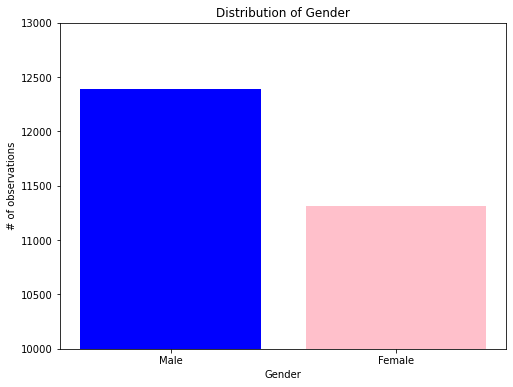

In [43]:
plt.figure(figsize=[8,6])
plt.bar(df['gender'].value_counts().index, df['gender'].value_counts().values, color = ["blue", "pink"])
plt.xlabel("Gender")
plt.ylabel("# of observations")
plt.title("Distribution of Gender")
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylim(10000, 13000)
plt.show()

The dataset contains more pictures of Males than Females. The imbalance is not that big, so it should not be a problem.

What about Ethnicity?

In [44]:
df['race'].value_counts()

0    10078
1     4529
3     3975
2     3434
4     1692
Name: race, dtype: int64

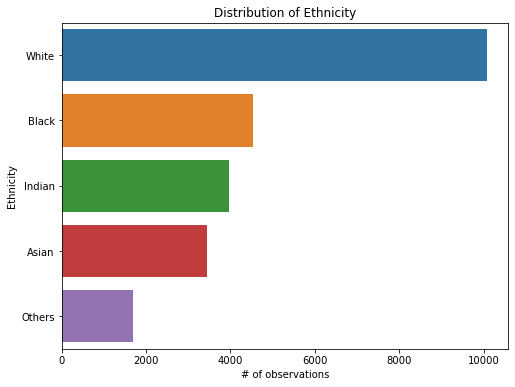

In [45]:
plt.figure(figsize=[8,6])
sns.barplot(x=list(df['race'].value_counts().values),
            y= list(df['race'].value_counts().index), 
            orient="h", 
            order=list(df['race'].value_counts().sort_values(ascending=False).index)
           )
plt.xlabel("# of observations")
plt.ylabel("Ethnicity")
plt.title("Distribution of Ethnicity")
plt.yticks(range(0,5), ["White", "Black", "Indian", "Asian", "Others"])
plt.show()

Here we see that the dataset is much more imbalanced. This should be taken into consideration when modelling.

What about the distributions of both Gender and Ethnicity?

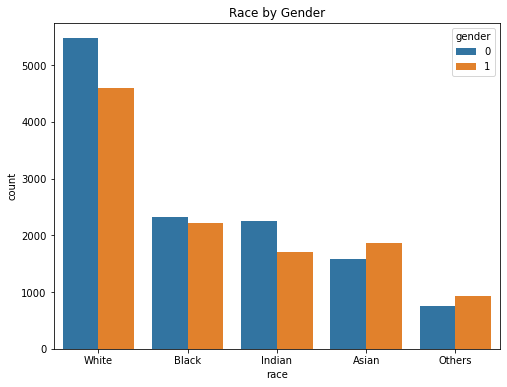

In [47]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='race', data=df, hue='gender', order=list(df['race'].value_counts().sort_values(ascending=False).index))
plt.xticks(range(0,5), ["White", "Black", "Indian", "Asian", "Others"])
plt.title("Race by Gender")
plt.show()

As we can see from the plot above, the Gender is not highly imbalanced between Ethicities.

Last but not least, let us check Age.

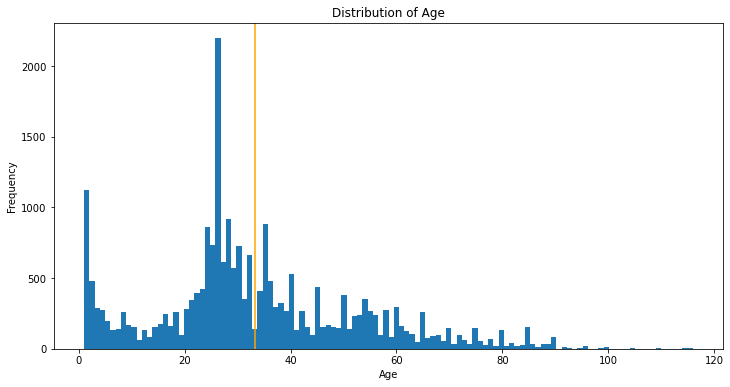

In [48]:
plt.figure(figsize=[12,6])
plt.hist(df['age'],
            bins = 116)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.axvline(df['age'].mean(), c = "orange")
plt.title("Distribution of Age")
plt.show()

In [49]:
df['age'].describe()

count    23708.000000
mean        33.303484
std         19.886112
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

As we can see, the mean age is arounf 33 years. Even though the Age data contains only round values, we should treat is as continuous and not categorical. It can be used for regression rather than classification. 

We can also plot the distribution of the image pixels and compare those between Gender and Ethnicity. The histograms would only give us general information regarding all the images from the corresponding class such as how dark or light are the images from this class [6]. For this purpose we will split our datasets based on Gender and Ethnicity and plot the pixels.

In [50]:
pixels_male = df[df["gender"] == 0].drop(["age","gender","race"], axis = 1)
pixels_female = df[df["gender"] == 1].drop(["age","gender","race"], axis = 1)

In [51]:
def generate_histogram_vector(data):
    list_of_pixels = []
    for row in data.values.tolist():
        list_of_pixels.append(row)
    
    hist_vector_flatten = list(itertools.chain(*list_of_pixels))
    
    return hist_vector_flatten

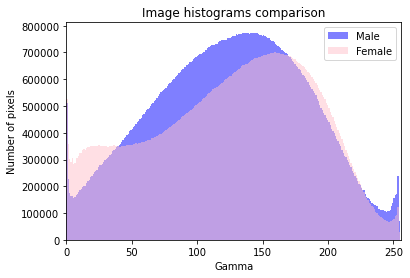

In [52]:
plt.hist(generate_histogram_vector(pixels_male), bins = 256, color = "blue", alpha = 0.5, label = "Male")
plt.hist(generate_histogram_vector(pixels_female), bins = 256, color = "pink", alpha = 0.5, label = "Female")
plt.xlim(0, 256)

plt.xlabel("Gamma")
plt.ylabel("Number of pixels")

plt.title("Image histograms comparison")
plt.legend()
plt.show()

The distribution of pixels for all female images seem similar to the one for all male pixels. There is only a fraction more dark pixels between 0 and 50 for the female images.

Let us do the same but now split the pixel distributions by Ethnicity.

In [53]:
pixels_white = df[df["race"] == 0].drop(["age","gender","race"], axis = 1)
pixels_black = df[df["race"] == 1].drop(["age","gender","race"], axis = 1)
pixels_asian = df[df["race"] == 2].drop(["age","gender","race"], axis = 1)
pixels_indian = df[df["race"] == 3].drop(["age","gender","race"], axis = 1)
pixels_other = df[df["race"] == 4].drop(["age","gender","race"], axis = 1)

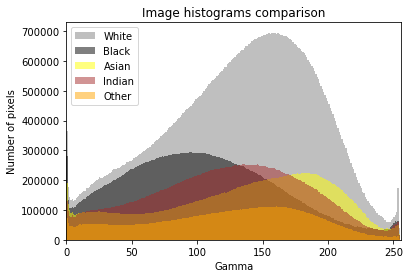

In [54]:
plt.hist(generate_histogram_vector(pixels_white), bins = 256, color = "gray", alpha = 0.5, label = "White")
plt.hist(generate_histogram_vector(pixels_black), bins = 256, color = "black", alpha = 0.5, label = "Black")
plt.hist(generate_histogram_vector(pixels_asian), bins = 256, color = "yellow", alpha = 0.5, label = "Asian")
plt.hist(generate_histogram_vector(pixels_indian), bins = 256, color = "brown", alpha = 0.5, label = "Indian")
plt.hist(generate_histogram_vector(pixels_other), bins = 256, color = "orange", alpha = 0.5, label = "Other")
plt.xlim(0, 256)

plt.xlabel("Gamma")
plt.ylabel("Number of pixels")

plt.title("Image histograms comparison")
plt.legend()
plt.show()

While discussing the  shapes of distributions of "White" and "Black" ethnicities might be a bit too racist, it should be noted that the shape of the distributions of "Indian" and "Other" are rather similar. It would be interesting to see if this will affect the modeling and thus the classification of those two classes.

## Data Preprocessing

In order to prepare our pixel data for modelling, we first need to scale the data, especially because we will be using the scikit-learn module[4]. This is to prevent a feature's higher variance to dominate the lower variance of other features. In this paper we will use sklearn's MinMaxScaler, which will scale our pixels to lie between 0 and 1.

In [55]:
df.head()

,age,gender,race,0,1,2,3,4,5,6,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
19500,56,0,0,253,252,251,248,233,199,141,...,84,106,133,164,194,211,213,203,202,211
22176,75,0,0,57,56,56,53,13,11,14,...,0,0,0,0,0,0,0,0,0,0
23043,86,0,3,98,99,107,114,147,206,228,...,108,106,113,120,113,114,112,114,120,116
17488,49,0,2,71,42,22,23,20,24,44,...,72,45,37,45,51,58,62,68,80,89
4292,24,0,2,75,79,82,76,76,75,76,...,211,186,149,130,130,126,131,133,134,133


In [56]:
features = df.drop(["age", "gender", "race"], axis = 1)

In [57]:
gender_label = df["gender"]

In [58]:
features_scaled = MinMaxScaler().fit_transform(features)
print(np.min(features_scaled), np.max(features_scaled))

0.0 1.0000000000000002


We will continue by splitting out data into a training and testing sets. This will be performed first on the Gender model.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    gender_label, 
                                                    test_size = 0.2, 
                                                    stratify = gender_label, 
                                                    random_state = 21)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18966, 10000) (4742, 10000) (18966,) (4742,)


Having 10,000 features is indeed too much. Using all of them will lead to poor performance of our model and we will become victims of the "curse of dimensionality" [5]. 

One common technique for reducing dimensionality is Principle Component Analysis (PCA). PCA is performed by first determining the covariance between features with a covariance matrix. After that we select the direction with maximum variance (eigenvalue) in the dataset, which is the first eigenvector (principal component). The next eigenvector will be orthogonal to the first, the third to the second and so on. The goal is PCA is to find the eigenvectors for a matrix and sort them in descending order by their eigenvalues. The extracted features with highest eigenvalues (the amount of variability explained) will be reatained, while the unimportant ones can be dropped[7]. 

This whole process can be done with several lines of code. Below we will instantiate a PCA, train it on the train features dataset and then transform both the train and test datasets. Since we do not know how many principal components will be needed to explain a certain percentage of the variation in the data, we specify the percentage of variability that we desire (in our case 95%) and the algorithm will drop the rest of the components that explain the variability above 95%.

In [60]:
pca = PCA(n_components = 0.95, random_state = 21)
pca = pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [62]:
with open('pca.pkl', 'wb') as pickle_file:
        pickle.dump(pca, pickle_file)

We can plot the first two components and check if they manage to separate the data into clusters.

In [63]:
first_pca, second_pca = X_train_pca[:, 0], X_train_pca[:, 1]

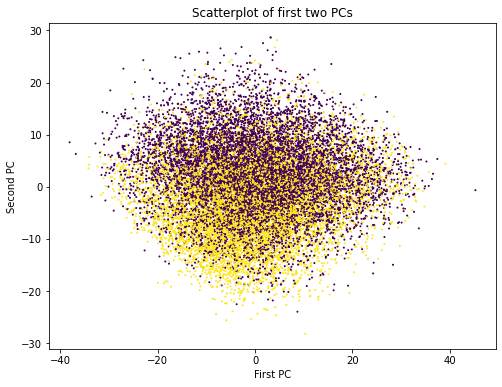

In [64]:
plt.figure(figsize=[8,6])
plt.scatter(first_pca, second_pca, c = y_train, s = 1)
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.title("Scatterplot of first two PCs")
plt.show()

This does not seem the case. Let us check how much variation do the separate components explain.

In [65]:
np.around(pca.explained_variance_ratio_, decimals=3)[:30]

array([0.287, 0.13 , 0.128, 0.045, 0.033, 0.028, 0.021, 0.017, 0.017,
       0.015, 0.014, 0.009, 0.009, 0.008, 0.008, 0.008, 0.006, 0.006,
       0.006, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.003, 0.003, 0.003])

The first PC explains around 29% of the variability, the second one around 13% and so on. The variability explained after the 12th component becomes less than 1%.

In [66]:
np.cumsum(np.around(pca.explained_variance_ratio_, decimals=4))

array([0.2875, 0.4177, 0.5459, 0.5914, 0.6242, 0.6522, 0.6733, 0.6906,
       0.7073, 0.7218, 0.7354, 0.7448, 0.7533, 0.7616, 0.7694, 0.777 ,
       0.7834, 0.7893, 0.7951, 0.8006, 0.8059, 0.8101, 0.8141, 0.8181,
       0.8221, 0.8258, 0.8294, 0.8328, 0.8361, 0.8392, 0.8422, 0.8451,
       0.8479, 0.8505, 0.8529, 0.8552, 0.8574, 0.8595, 0.8616, 0.8636,
       0.8656, 0.8675, 0.8694, 0.8712, 0.8729, 0.8746, 0.8763, 0.8778,
       0.8793, 0.8808, 0.8822, 0.8836, 0.885 , 0.8863, 0.8876, 0.8888,
       0.89  , 0.8912, 0.8923, 0.8934, 0.8945, 0.8956, 0.8966, 0.8976,
       0.8986, 0.8996, 0.9005, 0.9014, 0.9023, 0.9032, 0.9041, 0.905 ,
       0.9059, 0.9067, 0.9075, 0.9083, 0.9091, 0.9099, 0.9107, 0.9114,
       0.9121, 0.9128, 0.9135, 0.9142, 0.9149, 0.9156, 0.9162, 0.9168,
       0.9174, 0.918 , 0.9186, 0.9192, 0.9198, 0.9204, 0.921 , 0.9216,
       0.9222, 0.9228, 0.9233, 0.9238, 0.9243, 0.9248, 0.9253, 0.9258,
       0.9263, 0.9268, 0.9273, 0.9278, 0.9283, 0.9288, 0.9293, 0.9298,
      

The same idea can be conveyed with a cumulative sum array and we can also plot its contents to visualize it. 

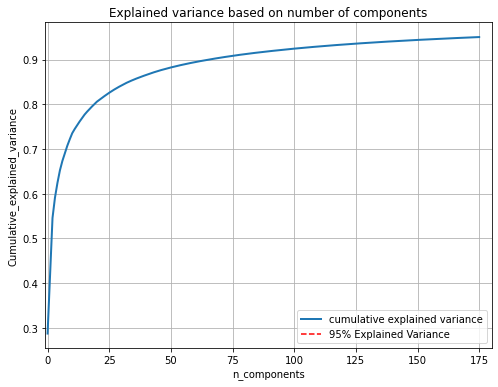

In [127]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2, label='cumulative explained variance')
plt.axis('tight')
plt.grid()
plt.xlim(left = -1, right = 180)
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.axhline(y = 95, color='red', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='lower right')
plt.title("Explained variance based on number of components")
plt.show()

In [68]:
X_train_pca.shape

(18966, 176)

From 10,000 features, we managed to retain 95% of the variability with only 176 principal components. Had we decreased the variability that we want to retain to 90% then the number of components would have been 67.

So what do these components look like? We can plot the first 15 ones to get a better idea.

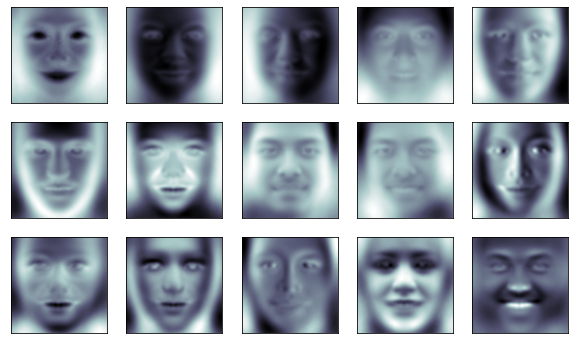

In [69]:
fig = plt.figure(figsize=(10, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(100,100),cmap=plt.cm.bone)

## Modeling for Gender classficiation

Now that we have decreased the number of features, we can try to build some classification models. For classifying Gender based on our 176 principal components, we will try the following models:

- Logistic regression
- Decision tree
- Random forest
- kNN
- Gaussian SVM

In order to tune our models, we will perform hyperparameter tuning and cross validation, and will utilize GridsearchCV. For the cross validation part, we willl split our training set in four parts:

In [70]:
k_fold = StratifiedKFold(n_splits = 4)

For measuring the performance of the models we will use we will use a weighted F1 score to avoid the bias introduced by non equal data for each class. For the Gender model the inbalance is not much, but we well stick to it just in case it is an issue.

Before performing hyperparameter tuning and cross validation, we will run a vanilla algorithm to get a feeling of how the data is predicted. For this purpose we will use Logistic regression. We resuse the same piece of code to run GridsearchCV from here onwards. The only difference here is that we so not specify any hyperparameters, as well as we specify no cross validation folds.

In [71]:
parameters_grid = [{
}]

scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search = GridSearchCV(LogisticRegression(max_iter=1000),
                           parameters_grid,
                           scoring = scorer,
                           cv = None,
                           n_jobs = -1)

grid_search.fit(X_train_pca, y_train)
lr_classifier = grid_search.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search.best_estimator_))
print("Logistic Regression; best score:", round(grid_search.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: LogisticRegression(max_iter=1000)
Logistic Regression; best score: 83.86%


Let us see some more metrics:

In [73]:
def plot_confusion_matrix_report(classifier, features, labels):

    conf_mat=confusion_matrix(labels, classifier.predict(features))
    
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat,
                annot=True,
                cmap = "Blues",
                fmt="d"
                )
    plt.xticks(range(0,len(y_train.unique())), ["Male", "Female"], rotation=45)
    plt.yticks(range(0,len(y_train.unique())), ["Male", "Female"], rotation=45)
    plt.show()

    print(classification_report(labels, classifier.predict(features)))

First let us do a confusion matrix and classification report on the train dataset.

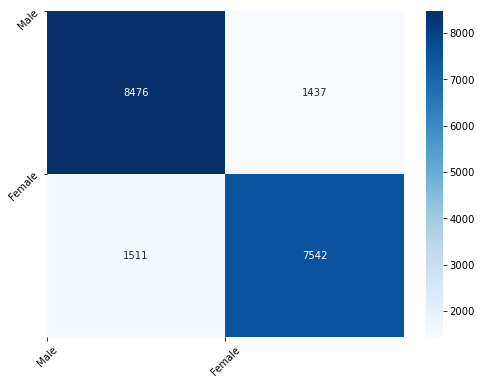

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      9913
           1       0.84      0.83      0.84      9053

    accuracy                           0.84     18966
   macro avg       0.84      0.84      0.84     18966
weighted avg       0.84      0.84      0.84     18966



In [74]:
plot_confusion_matrix_report(lr_classifier, X_train_pca, y_train)

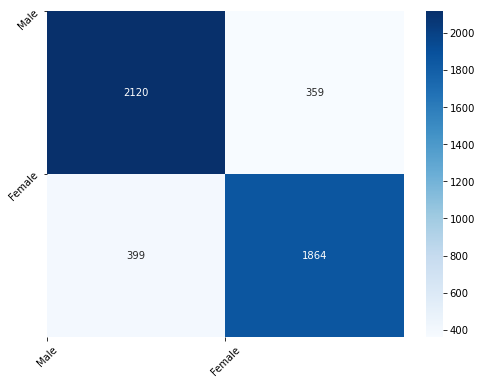

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2479
           1       0.84      0.82      0.83      2263

    accuracy                           0.84      4742
   macro avg       0.84      0.84      0.84      4742
weighted avg       0.84      0.84      0.84      4742



In [75]:
plot_confusion_matrix_report(lr_classifier, X_test_pca, y_test)

We see from the classification report that the imbalance of two classes has almost not effect on the results. The model returns a 84% F1 score on the training data and the same 84% on previously unseen data. This is a sign that there definitely is no overfitting. Whether the model sufferes from high bias we still do not know. It either has it or it is fine.

We can try to improve our model with hyperparameter tuning and that's what we will do next.

When performing gridsearch we would need to obtain information from the cv_results_ dictionary. For this purpose we will define the following functions:

In [76]:
def display_grid_results(grid_search):
    print(f'Best parameters are: {grid_search.best_params_}')
    print("\n")
    mean_score = grid_search.cv_results_['mean_test_score']
    std_score = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']
    for mean, std, params in zip(mean_score, std_score, params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

The first one outputs a 'report' of the best scores, their standard deviations and which hyperparameters have been used for the specific model. This will allow us to quickly see how the scores change and based on that adjust our hyperparameters.

In [77]:
columns_of_interest = ["split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score", "mean_test_score"]

def check_cross_validation(grid_search, columns_of_interest, threshold):
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df = cv_results_df[columns_of_interest]
    max_abs_diff = max(np.ptp(cv_results_df[columns_of_interest].values, axis=1))
    if max_abs_diff >= threshold:
        print(f"Check for an issue! The maximum absolute difference between any of the folds is: {max_abs_diff}")
    else:
        print("Cross validation seems to be fine!")

The second function deals with the cross validation part. It is iportant to have consistent results between the different folds. If we do not, then our model is seriously flawed. This is why we want to compare the score of each fold with the score of all the rest. We do not want to be looking at arrays with scores and compare them one by one. Instead we define a threshold for absolute difference between the folds. Differences below this threshols will be disregarded and we assume that the model is stable. If there are differences above the threshold, we receive a warning of the size of the difference.

For each algorithm, we will perform gridsearch and cross validation, after which we will select the best model and run it on previously unseen data, namely the test set we have split previously.

#### Logistic regression

Here we would like to see how a change in the regularization penalty affects the model. Since the default is 'l2' - Ridge, we would like to see the preformance of the 'l1' - Lasso. With the 'l1' penalty we will set some coefficients to zero, hile with the default 'l2' all coefficients are shrunk with the same value.

Also we will play around with C - the inverse regularization strength. Smaller values specify stronger regularization.

Last but not least we would like to try another solver and not the default 'lbfgs' one, which only accepts 'l2' penalty.

In [78]:
parameters_grid = [{
    "penalty": ["l1", "l2"],
    "C": [0.0001, 0.001, 0.01,1,10, 100, 1000, 10000],
    "solver": ["liblinear"]
}]
scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search = GridSearchCV(LogisticRegression(max_iter=1000),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search.fit(X_train_pca, y_train)
lr_classifier = grid_search.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search.best_estimator_))
print("Logistic Regression; best score:", round(grid_search.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')
Logistic Regression; best score: 83.88%


In [79]:
display_grid_results(grid_search)

Best parameters are: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


0.625 + or -0.006 for the {'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}
0.776 + or -0.009 for the {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.743 + or -0.008 for the {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
0.827 + or -0.005 for the {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.825 + or -0.006 for the {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.839 + or -0.004 for the {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.838 + or -0.005 for the {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.838 + or -0.005 for the {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.838 + or -0.004 for the {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.838 + or -0.004 for the {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.838 + or -0.004 for the {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.838 + or -0.004 for the {'C': 100, 'penalty': 'l2', 'solver': 'libline

In [80]:
check_cross_validation(grid_search, columns_of_interest, 0.05)

Cross validation seems to be fine!


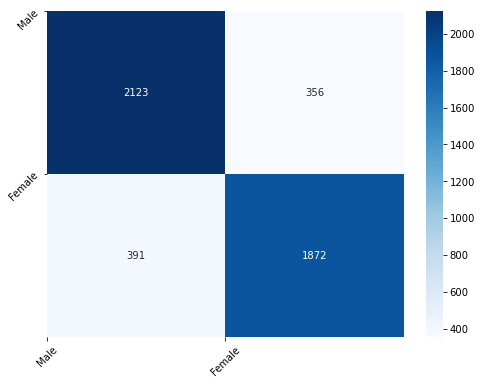

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2479
           1       0.84      0.83      0.83      2263

    accuracy                           0.84      4742
   macro avg       0.84      0.84      0.84      4742
weighted avg       0.84      0.84      0.84      4742



In [81]:
plot_confusion_matrix_report(lr_classifier, X_test_pca, y_test)

In [82]:
with open('lr_classifier.pkl', 'wb') as pickle_file:
        pickle.dump(lr_classifier, pickle_file)

We can see that very low values of C seem to regularize the model too much. Apart from that the regularization strength does not make much of a difference - this has to so with the fact that our data is scaled. In addition, we can see that the scores between the different folds of the corss validation do not differ by more than 5%, which implies that our algorithm is stable. The F1 scores from the cross validation suggest that the best model manages to classify with around 84% success on the validation data, while on previously unseen data it achieves a similar percentage - 84%. The similarity in results imply that there is no high variance and thus overfitting. There might be high bias, but we cannot conclude if this is the case. We will have to see how the other algorithms perform.

#### Decision Trees

The hyperparameters that we want to tune here are first the 'criterion' that measures the quality of the split. The 'entropy' measures the classification uncertainty, and 'gini' is pretty similar, with the only difference that 'gini' has less computations.

Secondly, 'max_depth' is the maximum depth of the tree. Higher depth tends to result in overfitting.

Last but not least, we want to play around with the 'min_samples_leaf' hyperparameter.

In [83]:
parameters_grid = [{
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 9, 13, 19],
    "min_samples_leaf": [1, 2, 5]
}]
scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_tree = GridSearchCV(DecisionTreeClassifier(),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_tree.fit(X_train_pca, y_train)
tree = grid_search_tree.best_estimator_

print("Decision tree; best estimator:", str(grid_search_tree.best_estimator_))
print("Decision tree; best score:", round(grid_search_tree.best_score_*100,2).astype(str) + "%")

Decision tree; best estimator: DecisionTreeClassifier(max_depth=9)
Decision tree; best score: 68.81%


In [84]:
display_grid_results(grid_search_tree)

Best parameters are: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1}


0.662 + or -0.004 for the {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
0.662 + or -0.004 for the {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2}
0.662 + or -0.004 for the {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
0.686 + or -0.004 for the {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
0.686 + or -0.004 for the {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}
0.686 + or -0.004 for the {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}
0.688 + or -0.005 for the {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1}
0.687 + or -0.005 for the {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2}
0.687 + or -0.005 for the {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5}
0.677 + or -0.004 for the {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 1}
0.673 + or -0.005 for the {'criterion': 'gini

In [85]:
check_cross_validation(grid_search_tree, columns_of_interest, 0.05)

Cross validation seems to be fine!


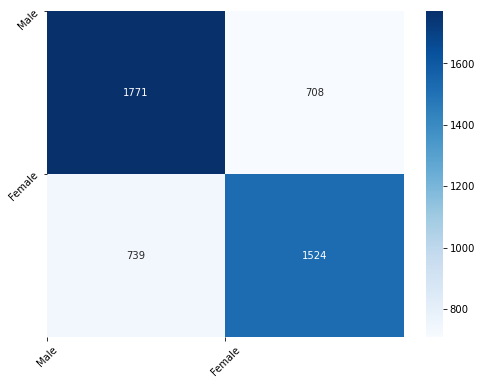

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2479
           1       0.68      0.67      0.68      2263

    accuracy                           0.69      4742
   macro avg       0.69      0.69      0.69      4742
weighted avg       0.69      0.69      0.69      4742



In [86]:
plot_confusion_matrix_report(tree,  X_test_pca, y_test)

Gini and Enthropy do not seem to provide different results, which was expected. Also the depth sweet spot seems to be around 9. Overall the model returns a F1 score of 69% on both train and test data. Since we have already got a higher F1 score, we can conclude that the model does not suffer from high variance, but does have high bias.

#### Random Forest

Here we fine-tune the following hyperparameters:

n_estimators: The default value here is 100, moreover if we select low number here the model will be closer to a decision tree. 

max_features: This defines how many features each tree is randomly assigned and we want to try both options: sqrt(n_features) and log2(n_features)

max_depth: same as the decision tree, we should be careful not to overfit with high gepth.

min_samples_leaf: Try setting these values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.

In [87]:
parameters_grid = [{
    "n_estimators": [200, 500, 800, 1300],
    "max_depth": [5, 9, 11, 13],
    "max_features": ["log2", "sqrt"]
}]
scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_forest = GridSearchCV(RandomForestClassifier(),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_forest.fit(X_train_pca, y_train)
forest_classifier = grid_search_forest.best_estimator_

print("Random forest; best estimator:", str(grid_search_forest.best_estimator_))
print("Random forest; best score:", round(grid_search_forest.best_score_*100,2).astype(str) + "%")

Random forest; best estimator: RandomForestClassifier(max_depth=13, max_features='log2', n_estimators=1300)
Random forest; best score: 82.22%


In [88]:
display_grid_results(grid_search_forest)

Best parameters are: {'max_depth': 13, 'max_features': 'log2', 'n_estimators': 1300}


0.755 + or -0.006 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
0.761 + or -0.003 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
0.76 + or -0.004 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 800}
0.76 + or -0.004 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 1300}
0.766 + or -0.005 for the {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
0.767 + or -0.006 for the {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
0.767 + or -0.006 for the {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 800}
0.769 + or -0.006 for the {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1300}
0.797 + or -0.004 for the {'max_depth': 9, 'max_features': 'log2', 'n_estimators': 200}
0.804 + or -0.008 for the {'max_depth': 9, 'max_features': 'log2', 'n_estimators': 500}
0.805 + or -0.003 for the {'max_d

In [89]:
check_cross_validation(grid_search_forest, columns_of_interest, 0.05)

Cross validation seems to be fine!


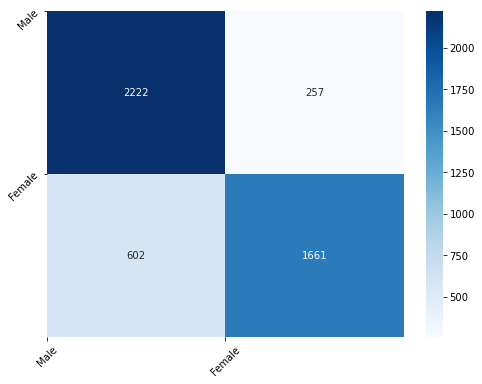

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      2479
           1       0.87      0.73      0.79      2263

    accuracy                           0.82      4742
   macro avg       0.83      0.82      0.82      4742
weighted avg       0.82      0.82      0.82      4742



In [90]:
plot_confusion_matrix_report(forest_classifier,  X_test_pca, y_test)

Recall of the less represented class is lower in this model compared to what we have seen before. Apart from that 82% on training and 82% F1 score on test data seems like no overfitting is present. 

#### k-nearest neighbors

Here we will select odd numbers for 'n_neighbors' to avoid possible tie results.

We will also try how both 'weights' options perform. The 'uniform' weight is the default one. With it all points in the neighborhood are weighted equally. Whereas 'distance' takeas account of the distance of the neighbors - closer ones have higher weight and more distanced ones - lower weight.

In [91]:
paramteters_grid = [{
    "n_neighbors": [7,9,11,13,15,17,19,21,23],
    "weights" : ["uniform", "distance"]
}]

scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_knn = GridSearchCV(KNeighborsClassifier(),
                           paramteters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_knn.fit(X_train_pca, y_train)
knn_classifier = grid_search_knn.best_estimator_

print("kNN; best estimator:", str(grid_search_knn.best_estimator_))
print("kNN; best score:", round(grid_search_knn.best_score_*100,2).astype(str) + "%")

kNN; best estimator: KNeighborsClassifier(n_neighbors=11, weights='distance')
kNN; best score: 74.61%


In [92]:
display_grid_results(grid_search_knn)

Best parameters are: {'n_neighbors': 11, 'weights': 'distance'}


0.733 + or -0.007 for the {'n_neighbors': 7, 'weights': 'uniform'}
0.74 + or -0.006 for the {'n_neighbors': 7, 'weights': 'distance'}
0.738 + or -0.007 for the {'n_neighbors': 9, 'weights': 'uniform'}
0.744 + or -0.007 for the {'n_neighbors': 9, 'weights': 'distance'}
0.739 + or -0.009 for the {'n_neighbors': 11, 'weights': 'uniform'}
0.746 + or -0.009 for the {'n_neighbors': 11, 'weights': 'distance'}
0.738 + or -0.008 for the {'n_neighbors': 13, 'weights': 'uniform'}
0.746 + or -0.007 for the {'n_neighbors': 13, 'weights': 'distance'}
0.737 + or -0.005 for the {'n_neighbors': 15, 'weights': 'uniform'}
0.744 + or -0.005 for the {'n_neighbors': 15, 'weights': 'distance'}
0.738 + or -0.005 for the {'n_neighbors': 17, 'weights': 'uniform'}
0.746 + or -0.006 for the {'n_neighbors': 17, 'weights': 'distance'}
0.738 + or -0.005 for the {'n_neighbors': 19, 'weights': 'uniform'}
0.746 + or -0.005 for the {'n_neighbors': 19, 'we

In [93]:
check_cross_validation(grid_search_knn, columns_of_interest, 0.05)

Cross validation seems to be fine!


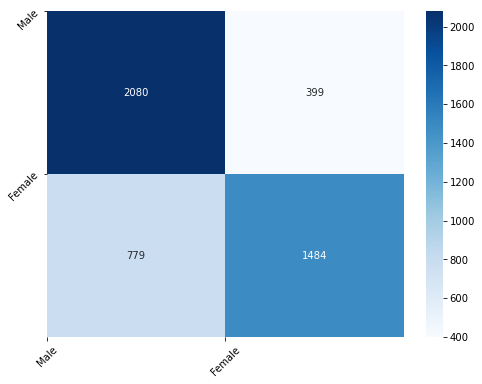

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2479
           1       0.79      0.66      0.72      2263

    accuracy                           0.75      4742
   macro avg       0.76      0.75      0.75      4742
weighted avg       0.76      0.75      0.75      4742



In [94]:
plot_confusion_matrix_report(knn_classifier,  X_test_pca, y_test)

The model performance does not seem to be affected by the hyperparameter tuning here. Obviously gridsearch here is not necessary.

#### SVM

Here we do not perform any hyperparameter tuning. The reason for this is that our computational power is simply not enough to allow for the training of the SVM to finish. Therefore we report the F1 scores of a vanila SVM.

In [96]:
paramteters_grid = [{ 
                    #'C': [0.001, 1, 1000],
                    #'kernel': ['linear', 'rbf']
}]

scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_svc = GridSearchCV(SVC(probability = True),
                           paramteters_grid,
                           scoring = scorer,
                           cv = None,
                           n_jobs = -1)

grid_search_svc.fit(X_train_pca, y_train)
svm_classifier = grid_search_svc.best_estimator_

print("SVM; best estimator:", str(grid_search_svc.best_estimator_))
print("SVM; best score:", round(grid_search_svc.best_score_*100,2).astype(str) + "%")

SVM; best estimator: SVC(probability=True)
SVM; best score: 85.72%


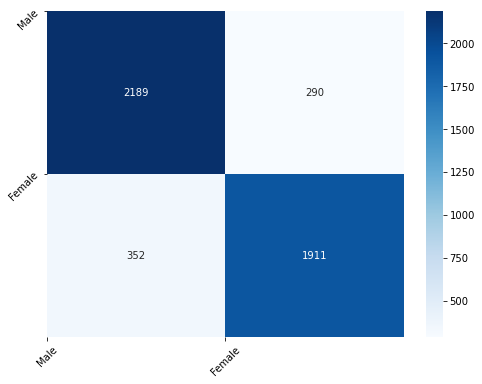

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2479
           1       0.87      0.84      0.86      2263

    accuracy                           0.86      4742
   macro avg       0.86      0.86      0.86      4742
weighted avg       0.86      0.86      0.86      4742



In [97]:
plot_confusion_matrix_report(svm_classifier, X_test_pca, y_test)

We have seen how the models performs, measured by F1 score, on both cross validation as well as on previously unseen test data. We want to look at some other metrics too. Let us compare the roc curves of all the models on the test dataset.

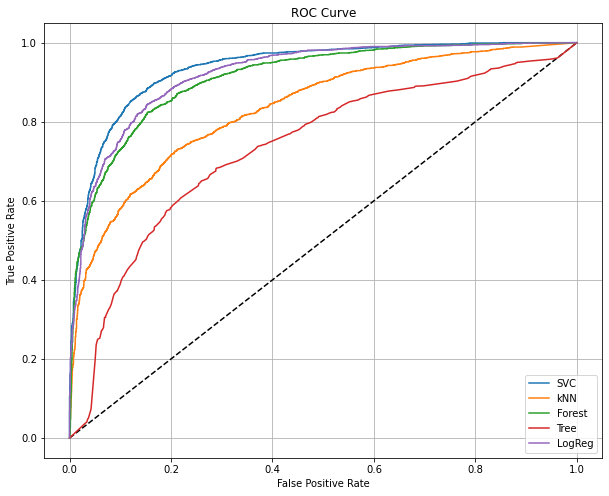

In [98]:
y_pred_prob_svm_classifier = svm_classifier.predict_proba(X_test_pca)[:,1]
y_pred_prob_knn_classifier = knn_classifier.predict_proba(X_test_pca)[:,1]
y_pred_prob_forest_classifier = forest_classifier.predict_proba(X_test_pca)[:,1]
y_pred_prob_tree = tree.predict_proba(X_test_pca)[:,1]  
y_pred_prob_lr_classifier = lr_classifier.predict_proba(X_test_pca)[:,1]  

# Generate ROC curve values: fpr, tpr, thresholds
fpr_svm_classifier, tpr_svm_classifier, thresholds_svm_classifier = roc_curve(y_test, y_pred_prob_svm_classifier)
fpr_knn_classifier, tpr_knn_classifier, thresholds_knn_classifier = roc_curve(y_test, y_pred_prob_knn_classifier)
fpr_forest_classifier, tpr_forest_classifier, thresholds_forest_classifier = roc_curve(y_test, y_pred_prob_forest_classifier)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_prob_tree)
fpr_lr_classifier, tpr_lr_classifier, thresholds_lr_classifier = roc_curve(y_test, y_pred_prob_lr_classifier)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm_classifier, tpr_svm_classifier, label = "SVC")
plt.plot(fpr_knn_classifier, tpr_knn_classifier, label = "kNN")
plt.plot(fpr_forest_classifier, tpr_forest_classifier, label = "Forest")
plt.plot(fpr_tree, tpr_tree, label = "Tree")
plt.plot(fpr_lr_classifier, tpr_lr_classifier, label = "LogReg")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

How about the time needed to fit each of the models?

In [99]:
time_svc = np.mean(grid_search_svc.cv_results_["mean_fit_time"])
time_knn = np.mean(grid_search_knn.cv_results_["mean_fit_time"])
time_forest = np.mean(grid_search_forest.cv_results_["mean_fit_time"])
time_tree = np.mean(grid_search_tree.cv_results_["mean_fit_time"])
time_logreg = np.mean(grid_search.cv_results_["mean_fit_time"])

In [100]:
grid_list = [
    time_svc,
    time_knn,
    time_forest,
    time_tree,
    time_logreg]

In [128]:
grid_list

[336.2637912273407,
 106.42320667393506,
 4.429265604416529,
 1.8160572515593634,
 1.364473931491375]

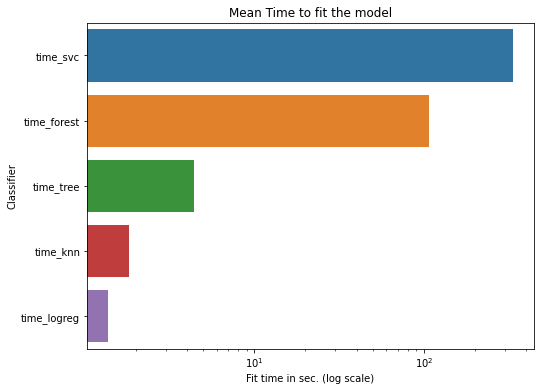

In [101]:
plt.figure(figsize=[8,6])
ax = sns.barplot(x= grid_list,
            y= ["time_svc","time_forest","time_tree","time_knn","time_logreg"], 
            orient="h", 
            order=grid_list.sort(reverse = True)
       )
ax.set(xscale="log")
plt.xlabel("Fit time in sec. (log scale)")
plt.ylabel("Classifier")
plt.title("Mean Time to fit the model")
plt.show()

When choosing the model we will conider both its performance in terms of a correctly classifying as well as how log it takes to train. SVC produced the best F1 score, however the Logistic Regression combines both high F1 and low mean fit time. **Therefore we will choose the Logistic regression.**

## Modeling for Ethnicity classficiation

As we saw from the EDA, the dataset is highly imbalanced when it comes to Ethnicity. This will require us to make some adjustments to our models. 

In order to avoid performing the same steps as with the Gender Model, we will focus on some of the techniques for dealing with highly imbalanced datasets. Namely, we will try both under and oversampling, and see which technique will serve us better in this particular instance.


Still we need to repeat some of the steps that we have performed for the previous model, such as split the data, and transform the features based on the pca that we have fit before.

In [103]:
race_label = df["race"]

In [104]:
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(features_scaled, 
                                                    race_label, 
                                                    test_size = 0.2, 
                                                    stratify = race_label, 
                                                    random_state = 21)

print(X_train_race.shape, X_test_race.shape, y_train_race.shape, y_test_race.shape)

(18966, 10000) (4742, 10000) (18966,) (4742,)


In [105]:
X_train_race_pca = pca.transform(X_train_race)
X_test_race_pca = pca.transform(X_test_race)

In [106]:
k_fold = StratifiedKFold(n_splits = 4)

Since we have a multiclass classification problem we will use a weighted acuracy    to avoid the bias introduced by non equal data for each class.

In [107]:
def plot_confusion_matrix_report_race(classifier, features, labels):

    conf_mat=confusion_matrix(labels, classifier.predict(features))
    
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat,
                annot=True,
                cmap = "Blues",
                fmt="d"
                )
    plt.xticks(range(0,len(labels.unique())), ["White", "Black", "Asian", "Indian", "Others"], rotation=45)
    plt.yticks(range(0,len(labels.unique())), ["White", "Black", "Asian", "Indian", "Others"], rotation=45)
    plt.show()

    print(classification_report(labels, classifier.predict(features)))

Before performing hyperparameter tuning and cross validation, we will run a vanilla algorithm to get a feeling of how the data is predicted. For this purpose we will use Logistic regression.

In [108]:
parameters_grid = [{
}]

scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_race_lr = GridSearchCV(LogisticRegression(max_iter=1000),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_race_lr.fit(X_train_race_pca, y_train_race)
lr_classifier_race = grid_search_race_lr.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search_race_lr.best_estimator_))
print("Logistic Regression; best score:", round(grid_search_race_lr.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: LogisticRegression(max_iter=1000)
Logistic Regression; best score: 68.75%


This time the Logistic Regression performs worse. Naturally the multiclass regression is more difficult to classify. 

In [109]:
check_cross_validation(grid_search_knn, columns_of_interest, 0.05)

Cross validation seems to be fine!


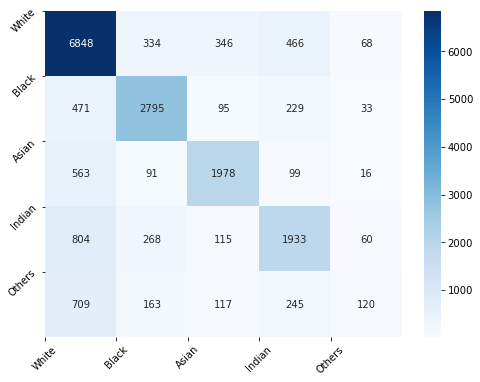

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      8062
           1       0.77      0.77      0.77      3623
           2       0.75      0.72      0.73      2747
           3       0.65      0.61      0.63      3180
           4       0.40      0.09      0.15      1354

    accuracy                           0.72     18966
   macro avg       0.66      0.61      0.61     18966
weighted avg       0.70      0.72      0.70     18966



In [110]:
plot_confusion_matrix_report_race(grid_search_race_lr, X_train_race_pca, y_train_race)

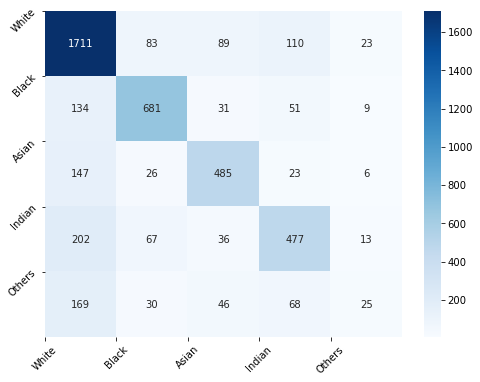

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      2016
           1       0.77      0.75      0.76       906
           2       0.71      0.71      0.71       687
           3       0.65      0.60      0.63       795
           4       0.33      0.07      0.12       338

    accuracy                           0.71      4742
   macro avg       0.64      0.60      0.60      4742
weighted avg       0.69      0.71      0.69      4742



In [111]:
plot_confusion_matrix_report_race(grid_search_race_lr, X_test_race_pca, y_test_race)

In [112]:
y_test_race.value_counts()

0    2016
1     906
3     795
2     687
4     338
Name: race, dtype: int64

Based on the cross validation and running the model on the test data, we see that our algorithm is having troubles to classify the underrepresented class. Only 25 correctly predicted 'Other' classes out 338 in total in the test dataset.



#### Oversampling

Here we will use Synthetic Minority Oversampling Technique (SMOTE). SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. We will use the default hyperparameters, which will result in SMOTE resampling all classes except the majority class. Thus we should end up with equal observations for each class.

In [113]:
oversample = SMOTE(random_state=21)

In [114]:
X_train_race_pca_os, y_train_race_os = oversample.fit_resample(X_train_race_pca, y_train_race)

In [115]:
y_train_race_os.value_counts()

4    8062
3    8062
2    8062
1    8062
0    8062
Name: race, dtype: int64

Now let us run out Logistic Regression and see how did the oversampling affected the results.

In [116]:
parameters_grid = [{
}]

scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_race_lr_os = GridSearchCV(LogisticRegression(max_iter=1000),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_race_lr_os.fit(X_train_race_pca_os, y_train_race_os)
lr_classifier_race_os = grid_search_race_lr_os.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search_race_lr_os.best_estimator_))
print("Logistic Regression; best score:", round(grid_search_race_lr_os.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: LogisticRegression(max_iter=1000)
Logistic Regression; best score: 69.87%


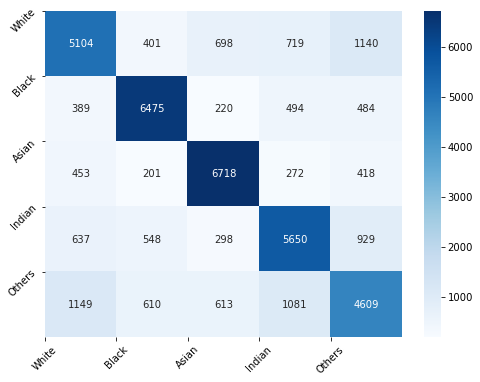

              precision    recall  f1-score   support

           0       0.66      0.63      0.65      8062
           1       0.79      0.80      0.79      8062
           2       0.79      0.83      0.81      8062
           3       0.69      0.70      0.69      8062
           4       0.61      0.57      0.59      8062

    accuracy                           0.71     40310
   macro avg       0.71      0.71      0.71     40310
weighted avg       0.71      0.71      0.71     40310



In [117]:
plot_confusion_matrix_report_race(grid_search_race_lr_os, X_train_race_pca_os, y_train_race_os)

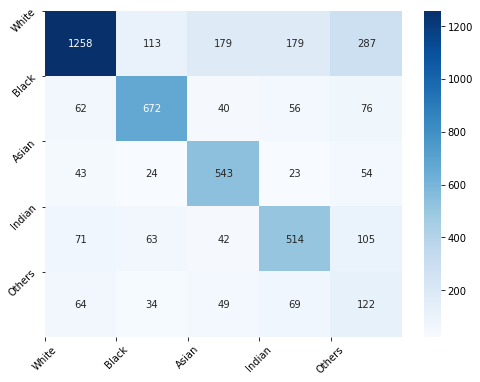

              precision    recall  f1-score   support

           0       0.84      0.62      0.72      2016
           1       0.74      0.74      0.74       906
           2       0.64      0.79      0.71       687
           3       0.61      0.65      0.63       795
           4       0.19      0.36      0.25       338

    accuracy                           0.66      4742
   macro avg       0.60      0.63      0.61      4742
weighted avg       0.71      0.66      0.67      4742



In [118]:
plot_confusion_matrix_report_race(grid_search_race_lr_os, X_test_race_pca, y_test_race)

There is some improvement as the F1 score for the test data increased from 10% to 25%. We would, however, also like to try the opposite - undersampling all classes but the minority one.

In [172]:
undersample = RandomUnderSampler(random_state=21)

In [173]:
X_train_race_pca_us, y_train_race_us = undersample.fit_resample(X_train_race_pca, y_train_race)

In [174]:
y_train_race_us.value_counts()

3    1354
2    1354
1    1354
4    1354
0    1354
Name: race, dtype: int64

In [176]:
parameters_grid = [{
}]

scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_race_lr_us = GridSearchCV(LogisticRegression(max_iter=1000),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_race_lr_us.fit(X_train_race_pca_us, y_train_race_us)
lr_classifier_race_us = grid_search_race_lr_us.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search_race_lr_us.best_estimator_))
print("Logistic Regression; best score:", round(grid_search_race_lr_us.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: LogisticRegression(max_iter=1000)
Logistic Regression; best score: 62.36%


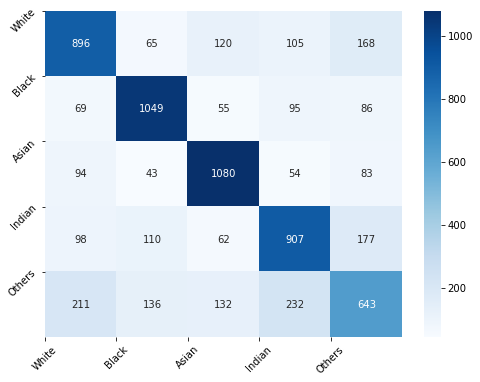

              precision    recall  f1-score   support

           0       0.65      0.66      0.66      1354
           1       0.75      0.77      0.76      1354
           2       0.75      0.80      0.77      1354
           3       0.65      0.67      0.66      1354
           4       0.56      0.47      0.51      1354

    accuracy                           0.68      6770
   macro avg       0.67      0.68      0.67      6770
weighted avg       0.67      0.68      0.67      6770



In [177]:
plot_confusion_matrix_report_race(lr_classifier_race_us, X_train_race_pca_us, y_train_race_us)

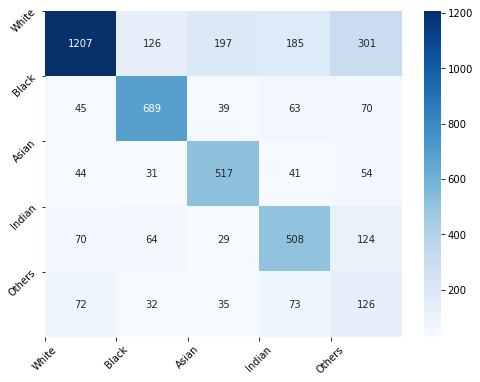

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      2016
           1       0.73      0.76      0.75       906
           2       0.63      0.75      0.69       687
           3       0.58      0.64      0.61       795
           4       0.19      0.37      0.25       338

    accuracy                           0.64      4742
   macro avg       0.59      0.62      0.60      4742
weighted avg       0.70      0.64      0.66      4742



In [178]:
plot_confusion_matrix_report_race(lr_classifier_race_us, X_test_race_pca, y_test_race)

As we see the situation when undersampling is not radically better than when we oversample. Since we lose training data and since the f1 scores do not improve at all, we will proceed with using the oversampled data.

#### Logistic regression

In [119]:
parameters_grid = [{
    "penalty": ["l1", "l2"],
    "C": [0.0001, 0.001, 0.01,1,10, 100, 1000, 10000],
    "solver": ["liblinear"]
}]
scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_race_lr_os = GridSearchCV(LogisticRegression(max_iter=1000),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_race_lr_os.fit(X_train_race_pca_os, y_train_race_os)
lr_classifier_race = grid_search_race_lr_os.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search_race_lr_os.best_estimator_))
print("Logistic Regression; best score:", round(grid_search_race_lr_os.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')
Logistic Regression; best score: 69.4%


In [120]:
display_grid_results(grid_search_race_lr_os)

Best parameters are: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


0.213 + or -0.003 for the {'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}
0.574 + or -0.013 for the {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.522 + or -0.013 for the {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
0.662 + or -0.02 for the {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.659 + or -0.022 for the {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.69 + or -0.023 for the {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.694 + or -0.024 for the {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.694 + or -0.024 for the {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.694 + or -0.024 for the {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.694 + or -0.024 for the {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.694 + or -0.024 for the {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.694 + or -0.024 for the {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [121]:
check_cross_validation(grid_search_race_lr_os, columns_of_interest, 0.05)

Check for an issue! The maximum absolute difference between any of the folds is: 0.06423578282463693


This value is acceptable and we chose to ignore the warning.

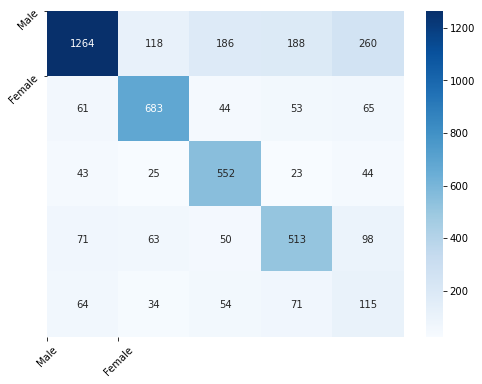

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      2016
           1       0.74      0.75      0.75       906
           2       0.62      0.80      0.70       687
           3       0.60      0.65      0.62       795
           4       0.20      0.34      0.25       338

    accuracy                           0.66      4742
   macro avg       0.60      0.63      0.61      4742
weighted avg       0.70      0.66      0.67      4742



In [122]:
plot_confusion_matrix_report(lr_classifier_race,  X_test_race_pca, y_test_race)

#### Random Forest

In [123]:
parameters_grid = [{
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 5, 6, 7],
    "max_features": ["log2"]
}]
scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

grid_search_forest_race_os = GridSearchCV(RandomForestClassifier(),
                           parameters_grid,
                           scoring = scorer,
                           cv = k_fold,
                           n_jobs = -1)

grid_search_forest_race_os.fit(X_train_race_pca_os, y_train_race_os)
forest_classifier_os = grid_search_forest_race_os.best_estimator_

print("Logistic Regression; best estimator:", str(grid_search_forest_race_os.best_estimator_))
print("Logistic Regression; best score:", round(grid_search_forest_race_os.best_score_*100,2).astype(str) + "%")

Logistic Regression; best estimator: RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=300)
Logistic Regression; best score: 68.31%


In [124]:
display_grid_results(grid_search_forest_race_os)

Best parameters are: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 300}


0.571 + or -0.028 for the {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}
0.581 + or -0.029 for the {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.579 + or -0.031 for the {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 300}
0.596 + or -0.031 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
0.607 + or -0.034 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
0.612 + or -0.033 for the {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 300}
0.628 + or -0.034 for the {'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}
0.641 + or -0.033 for the {'max_depth': 6, 'max_features': 'log2', 'n_estimators': 200}
0.646 + or -0.034 for the {'max_depth': 6, 'max_features': 'log2', 'n_estimators': 300}
0.663 + or -0.028 for the {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 100}
0.678 + or -0.034 for the {'max_dep

In [129]:
check_cross_validation(grid_search_forest_race_os, columns_of_interest, 0.05)

Cross validation seems to be fine!


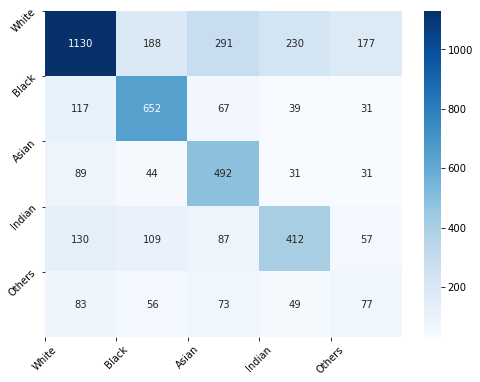

              precision    recall  f1-score   support

           0       0.73      0.56      0.63      2016
           1       0.62      0.72      0.67       906
           2       0.49      0.72      0.58       687
           3       0.54      0.52      0.53       795
           4       0.21      0.23      0.22       338

    accuracy                           0.58      4742
   macro avg       0.52      0.55      0.53      4742
weighted avg       0.60      0.58      0.59      4742



In [126]:
plot_confusion_matrix_report_race(forest_classifier_os,  X_test_race_pca, y_test_race)

The Random forest model returns a 68% F1 score on the validation and only 59% F1 score on the test data. This is the result after seveal iterations in which we have decreased the 'max_depth' hyperparameter. Thisis the lowest variance managed to achive without increasing the bias too much. 

**Again based on the results we will chose the Linear regression as the clear winner.**

## Concluding Remarks

There are several ares in which this paper can be improved:

- First and foremost, as part of this dataset there is an opportunity to also build a regression model for Age prediction.
- In addition, it would be interesting to compare how a CNN model would perform compared to our models. 
- Also combining the Age and Ethnicity (cartesian product) into 2 x 5 = 10 classes and trying to predict both with a single model would be an interesting exercise.
- Using hyperparameter tuning can also be performed for the Over/Undersampling as well as the Dimensionality reduction that we have performed.
- Packing everything into a pipeline would also be a positive step forward in further developing this paper.


On a positive note the results achieved in this paper are not far-off from previous publicly available work on this data.

## References

Data sources: 
https://susanqq.github.io/UTKFace/

[1] https://en.wikipedia.org/wiki/Computer_vision

[2] https://heartbeat.fritz.ai/the-5-computer-vision-techniques-that-will-change-how-you-see-the-world-1ee19334354b

[3] https://en.wikipedia.org/wiki/Eigenface

[4] https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

[5] https://en.wikipedia.org/wiki/Curse_of_dimensionality

[6] http://www.sci.utah.edu/~gerig/CS6640-F2012/Materials/greylevel_transformation_GG.pdf

[7] https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html